#  Predictive Modeling on Imbalanced-Label Datasets

The goal of this Jupyter notebook is to explore ways to create predictive models for classifying datasets with imbalanced labels.

We will look at Default dataset from the ISLR package. 

## Exploratory Data Analysis

In [1]:
# Load packages
library(MASS)
library(ISLR)
library(rpart)
library(ROSE)
library(DMwR)
library(ggplot2)
attach(Default)

Loaded ROSE 0.0-3

Loading required package: lattice
Loading required package: grid


Let's first check the the size of the data and the name of the predictors

In [2]:
print(sprintf('The number of observations and predictors of the Default data are %d and %d.',nrow(Default),ncol(Default)))

[1] "The number of observations and predictors of the Default data are 10000 and 4."


The names of the predictors are 

In [2]:
names(Default)
head(Default)

[1] "default" "student" "balance" "income"

default,student,balance,income
No,No,729.5265,44361.625
No,Yes,817.1804,12106.135
No,No,1073.5492,31767.139
No,No,529.2506,35704.494
No,No,785.6559,38463.496
No,Yes,919.5885,7491.559


Now let us get a general idea of the distribution of default as a function of income and balance. Notice that default occurred at various income levels. The plot suggests that default is more correlated to balance remaining. 

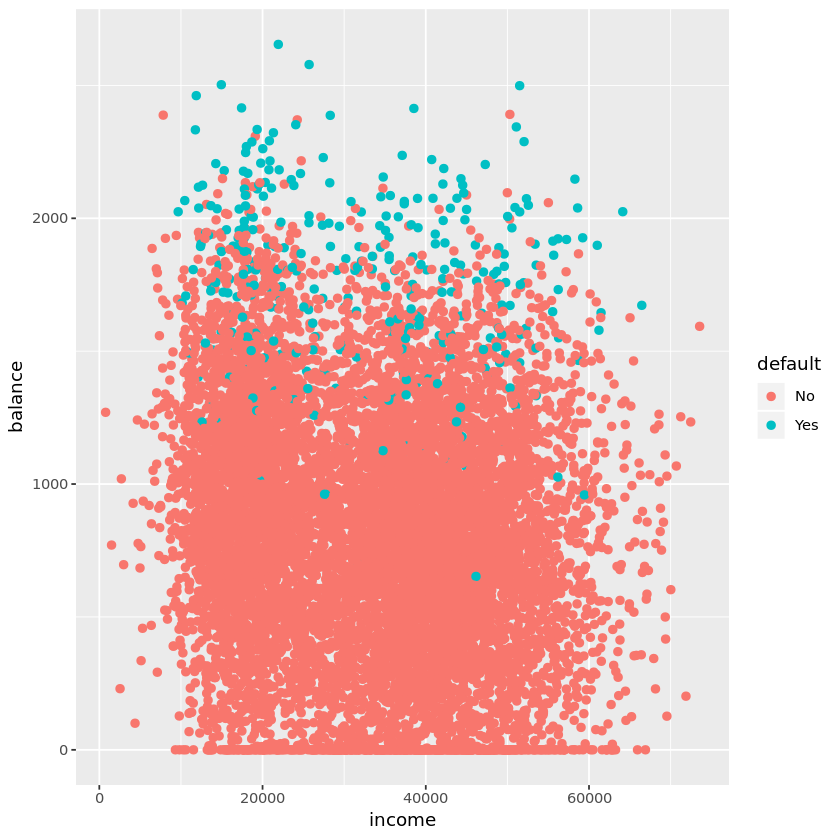

In [2]:
ggplot(data=Default,aes(income,balance,color=default)) + geom_point(size=2)

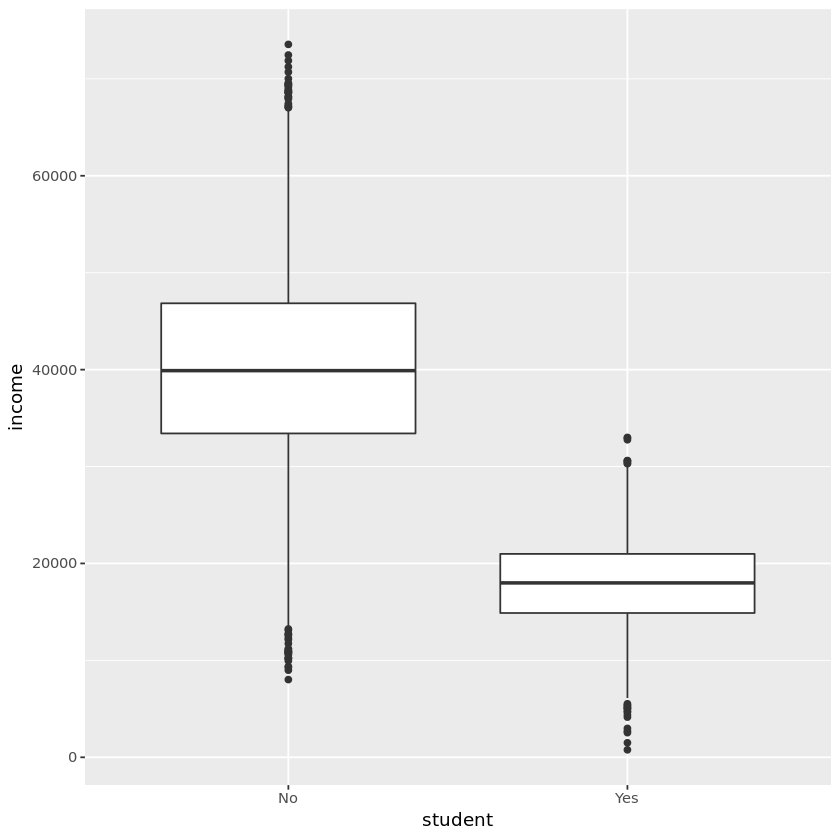

In [4]:
ggplot(data=Default,aes(student,income))+geom_boxplot()

[1] 127

[1] 206

[1] 2944

[1] 2944

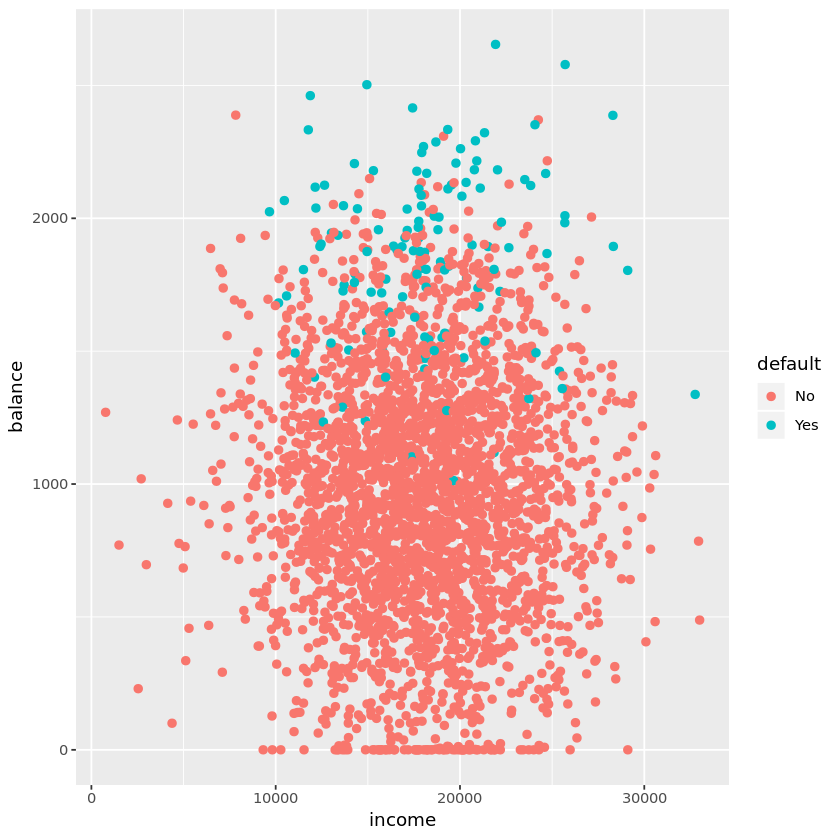

In [15]:
students = Default[Default$student=='Yes',]
non_students = Default[Default$student=='No',]
sum(students$default=='Yes')
sum(non_students$default=='Yes')
sum(Default$student=='Yes')
nrow(students)
ggplot(data=students,aes(income,balance,color=default)) + geom_point(size=2)

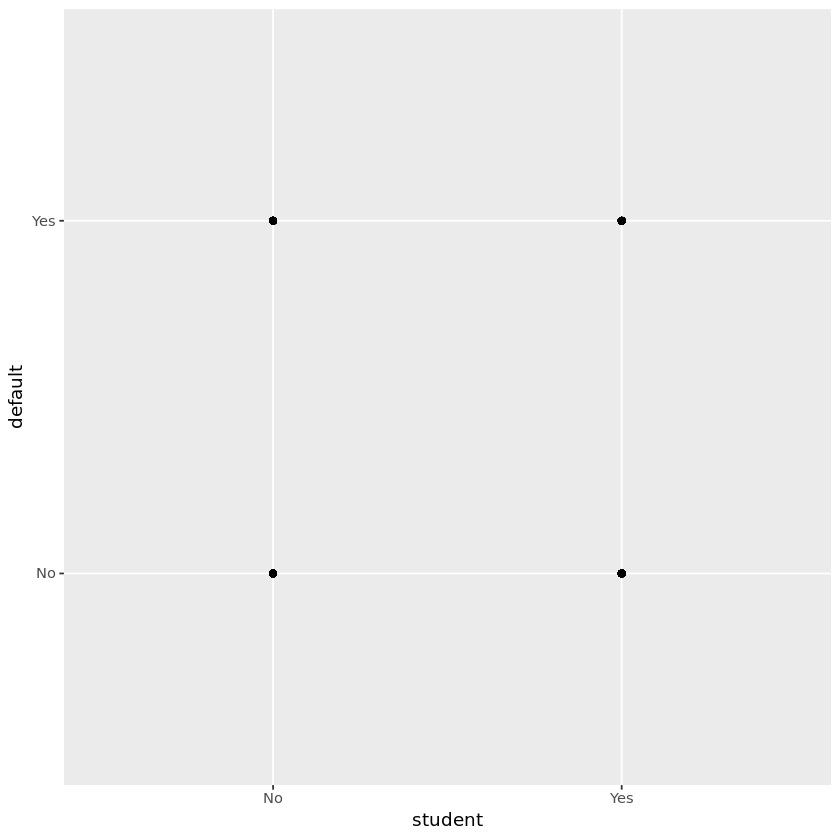

In [10]:
ggplot(data=Default,aes(student,default)) + geom_point()

It seems majority of the people do not default. Let's check how balanced is the default labels

In [5]:
table(Default$default)


  No  Yes 
9667  333 

The default percentage of the population is

In [6]:
(sum(Default$default=='Yes')/nrow(Default))*100

[1] 3.33

Notice that there are more non-defaulters (No) than defaulters (Yes). A normal classifier will accurately predict non-defaulters on a test data. 

There are several strategies for treating imbalanced dataset such as Default. We consider four strategies applying on the training set: oversampling, undersampling, both, and generation of synthetic data by randomly over sampling Examples (ROSE).

First we do we training and test sets split. The training set will contain the first 5,000 observations, and the remaining observations will be our test set. 

After creating balanced training sets using different sampling methods, we train a logistic regression classifier for each balanced training set. Then, we compare how the model performs on the test set with different balanced training set.

## Building a classifier based on balanced training data

In [16]:
# Now we do training and test split
# We do 50/50 split.
ind = 0.5*length(default)
train = Default[1:ind,]
test = Default[(ind+1):length(default),]
default_test = default[(ind+1):length(default)]


# Balance training data
#over sampling
data_balanced_over <- ovun.sample(default ~ ., data =train, method = "over", p=0.5 , seed = 2)$data
#Undersampling
data_balanced_under <- ovun.sample(default ~ ., data =train, method = "under", p=0.5 , seed = 2)$data
#Both (balanced data set with both over and under sampling)
data_balanced_both <- ovun.sample(default ~ ., data =train, method = "both", p=0.5 , seed = 2)$data
#ROSE (creates a sample of synthetic data by enlarging the features space of minority and majority class examples)
data.rose = ROSE(default~.,data=train,seed=1)$data
#SMOTE: artificially generate new examples of the minority class using the nearest neighbors. 
#The majority class examples are also under-sampled.
data_smote <- SMOTE(default~., data=train) 


# Train logistic classifier on normal training and test split.
glm.normal = glm(default~.,data=train,family=binomial)
glm.normal.probs = predict(glm.normal,test,type='response')
glm.normal.pred= rep('No',5000)
glm.normal.pred[glm.normal.probs>.5] = 'Yes'
table(glm.normal.pred,truth = test$default)

# Train logistic classifiers on the four balanced training sets.
# up sampling 
glm.over = glm(default~.,data=data_balanced_over,family=binomial)
glm.over.probs = predict(glm.over,test,type='response')
glm.over.pred= rep('No',5000)
glm.over.pred[glm.over.probs>.5] = 'Yes'
table(glm.over.pred,truth = test$default)


# under sampling
data_balanced_under <- ovun.sample(default ~ ., data =train, method = "under", p=0.5 , seed = 2)$data
glm.under = glm(default~.,data=data_balanced_under,family=binomial)
glm.under.probs = predict(glm.under,test,type='response')
glm.under.pred= rep('No',5000)
glm.under.pred[glm.under.probs>.5] = 'Yes'
table(glm.under.pred,truth = test$default)


# balanced both
data_balanced_both <- ovun.sample(default ~ ., data =train, method = "both", p=0.6 , seed = 1)$data
glm.both = glm(default~.,data=data_balanced_both,family=binomial)
glm.both.probs = predict(glm.both,test,type='response')
glm.both.pred= rep('No',5000)
glm.both.pred[glm.both.probs>.5] = 'Yes'
table(glm.both.pred,truth = test$default)


# Rose method
data.rose = ROSE(default~.,data=train,seed=1)$data
glm.rose = glm(default~.,data=data.rose,family=binomial)
glm.rose.probs = predict(glm.rose,test,type='response')
#glm.rose.transformed = sqrt(glm.rose.probs)
glm.rose.pred= rep('No',5000)
#glm.rose.transformed.pred = rep('No',5000)
glm.rose.pred[glm.rose.probs>.5] = 'Yes'
#glm.rose.transformed.pred[glm.rose.transformed >.5] = 'Yes'
table(glm.rose.pred,test$default)
#table(prediction = glm.rose.transformed.pred,actual=test$default)

# SMOTE method 
glm.smote = glm(default~.,data=data_smote,family=binomial)
glm.smote.probs = predict(glm.smote,test,type='response')
#head(glm.smote.probs)
#glm.smote.transformed = (glm.smote.probs)^(1/2)
glm.smote.pred= rep('No',5000)
#glm.transformed.pred = rep('No',5000)
glm.smote.pred[glm.smote.probs>.5] = 'Yes'
#glm.transformed.pred[glm.smote.transformed >.5] = 'Yes'
table(glm.smote.pred,truth = test$default)
#table(glm.transformed.pred,test$default)
#head(test$default)

               truth
glm.normal.pred   No  Yes
            No  4816  105
            Yes   26   53

             truth
glm.over.pred   No  Yes
          No  4152   19
          Yes  690  139

              truth
glm.under.pred   No  Yes
           No  4157   19
           Yes  685  139

             truth
glm.both.pred   No  Yes
          No  4024   15
          Yes  818  143

             
glm.rose.pred   No  Yes
          No  4163   19
          Yes  679  139

              truth
glm.smote.pred   No  Yes
           No  4288   26
           Yes  554  132

We can visualize how well each of our new models do in ROC curves and AUC metric. The AUC scores and ROC suggest indifference among the sampling methods. Nevertheless, any of of the approches here outperforms AUC score training based on imbalanced training dataset.

Area under the curve (AUC): 0.665

Area under the curve (AUC): 0.869

Area under the curve (AUC): 0.869

Area under the curve (AUC): 0.868

Area under the curve (AUC): 0.870

Area under the curve (AUC): 0.861

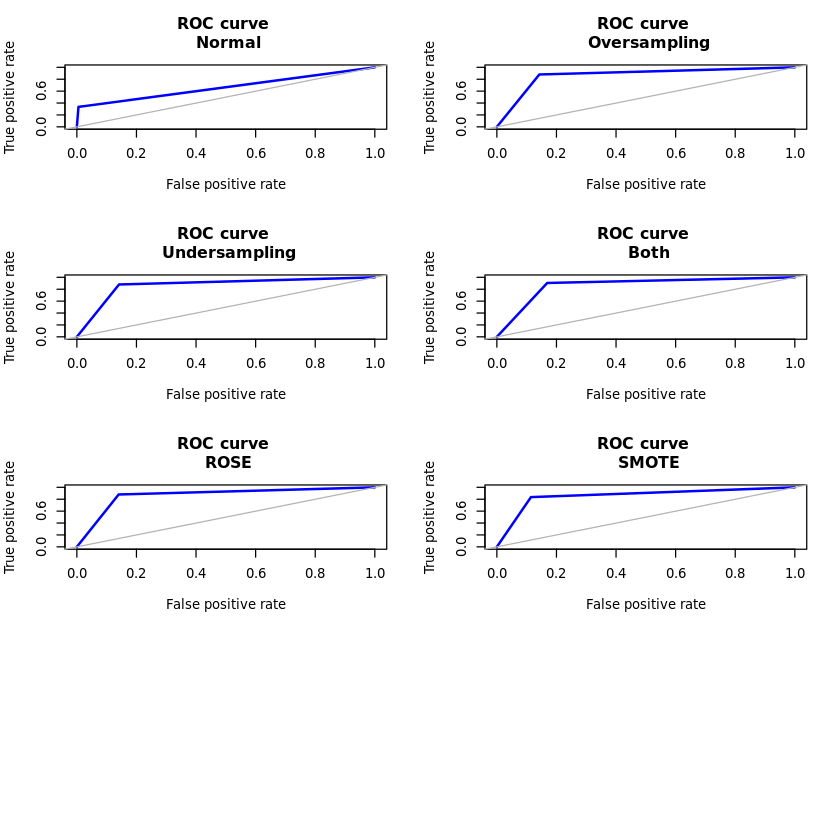

In [17]:
par(mfrow=c(4,2))
roc.curve(test$default,glm.normal.pred,  main="ROC curve \n Normal", col ='blue')
roc.curve(test$default,glm.over.pred,  main="ROC curve \n Oversampling", col ='blue')
roc.curve(test$default,glm.under.pred,  main="ROC curve \n Undersampling", col='blue')
roc.curve(test$default,glm.both.pred,  main="ROC curve \n Both", col='blue')
roc.curve(test$default,glm.rose.pred, main = 'ROC curve \n ROSE', col='blue')
#roc.curve(test$default,glm.rose.transformed.pred, main='ROC curve \n ROSE and Transformed', col='blue')
roc.curve(test$default,glm.smote.pred, main = 'ROC curve \n SMOTE', col='blue')
#roc.curve(test$default,glm.transformed.pred,main = 'ROC curve \n SMOTE and Transformed', col='blue')

### How sensitive is the threshold value on classification performance?

In [18]:
# Suppose we change the how we determine the no vs yes default threshold value.
# Instead of 0.5, let's do 0.3 instead.


# Train logistic classifier on normal training and test split.
glm.normal = glm(default~.,data=train,family=binomial)
glm.normal.probs = predict(glm.normal,test,type='response')
glm.normal.pred= rep('No',5000)
glm.normal.pred[glm.normal.probs>.3] = 'Yes'
table(glm.normal.pred,truth = test$default)

# Train logistic classifiers on the four balanced training sets.
# up sampling 
glm.over = glm(default~.,data=data_balanced_over,family=binomial)
glm.over.probs = predict(glm.over,test,type='response')
glm.over.pred= rep('No',5000)
glm.over.pred[glm.over.probs>.3] = 'Yes'
table(glm.over.pred,truth = test$default)


# under sampling
data_balanced_under <- ovun.sample(default ~ ., data =train, method = "under", p=0.5 , seed = 2)$data
glm.under = glm(default~.,data=data_balanced_under,family=binomial)
glm.under.probs = predict(glm.under,test,type='response')
glm.under.pred= rep('No',5000)
glm.under.pred[glm.under.probs>.3] = 'Yes'
table(glm.under.pred,truth = test$default)


# balanced both
data_balanced_both <- ovun.sample(default ~ ., data =train, method = "both", p=0.6 , seed = 1)$data
glm.both = glm(default~.,data=data_balanced_both,family=binomial)
glm.both.probs = predict(glm.both,test,type='response')
glm.both.pred= rep('No',5000)
glm.both.pred[glm.both.probs>.3] = 'Yes'
table(glm.both.pred,truth = test$default)


# Rose method
data.rose = ROSE(default~.,data=train,seed=1)$data
glm.rose = glm(default~.,data=data.rose,family=binomial)
glm.rose.probs = predict(glm.rose,test,type='response')
#glm.rose.transformed = sqrt(glm.rose.probs)
glm.rose.pred= rep('No',5000)
#glm.rose.transformed.pred = rep('No',5000)
glm.rose.pred[glm.rose.probs>.3] = 'Yes'
#glm.rose.transformed.pred[glm.rose.transformed >.5] = 'Yes'
table(glm.rose.pred,test$default)
#table(prediction = glm.rose.transformed.pred,actual=test$default)

# SMOTE method 
glm.smote = glm(default~.,data=data_smote,family=binomial)
glm.smote.probs = predict(glm.smote,test,type='response')
#head(glm.smote.probs)
#glm.smote.transformed = (glm.smote.probs)^(1/2)
glm.smote.pred= rep('No',5000)
#glm.transformed.pred = rep('No',5000)
glm.smote.pred[glm.smote.probs>.3] = 'Yes'
#glm.transformed.pred[glm.smote.transformed >.5] = 'Yes'
table(glm.smote.pred,truth = test$default)
#table(glm.transformed.pred,test$default)
#head(test$default)

               truth
glm.normal.pred   No  Yes
            No  4754   76
            Yes   88   82

             truth
glm.over.pred   No  Yes
          No  3815   12
          Yes 1027  146

              truth
glm.under.pred   No  Yes
           No  3768   12
           Yes 1074  146

             truth
glm.both.pred   No  Yes
          No  3621    7
          Yes 1221  151

             
glm.rose.pred   No  Yes
          No  3766   11
          Yes 1076  147

              truth
glm.smote.pred   No  Yes
           No  3995   15
           Yes  847  143

Area under the curve (AUC): 0.750

Area under the curve (AUC): 0.856

Area under the curve (AUC): 0.857

Area under the curve (AUC): 0.849

Area under the curve (AUC): 0.852

Area under the curve (AUC): 0.865

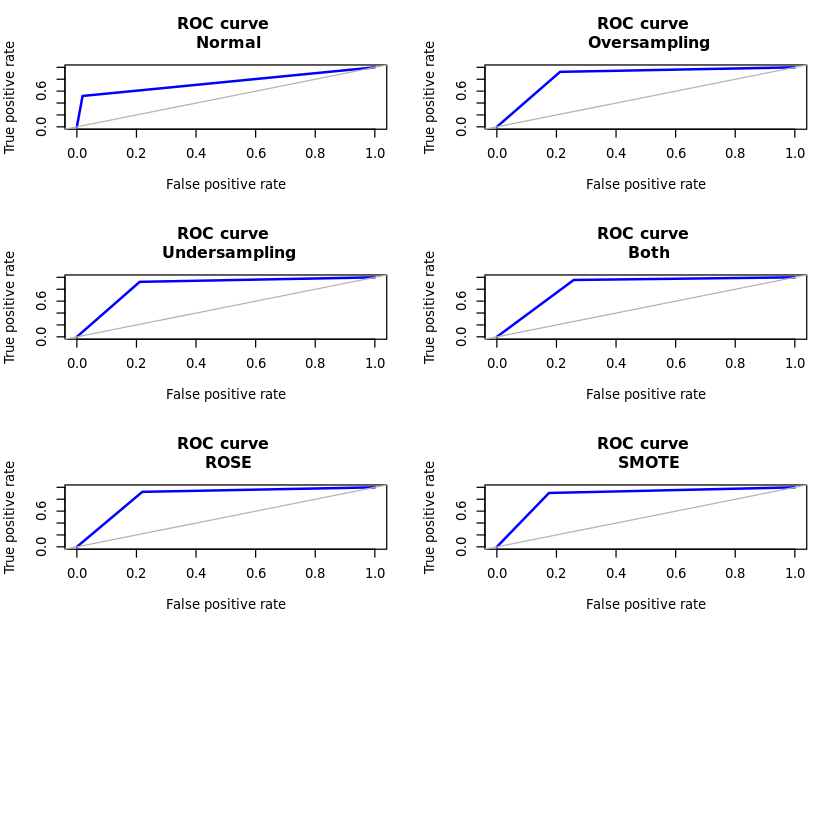

In [34]:
par(mfrow=c(4,2))
roc.curve(test$default,glm.normal.pred,  main="ROC curve \n Normal", col ='blue')
roc.curve(test$default,glm.over.pred,  main="ROC curve \n Oversampling", col ='blue')
roc.curve(test$default,glm.under.pred,  main="ROC curve \n Undersampling", col='blue')
roc.curve(test$default,glm.both.pred,  main="ROC curve \n Both", col='blue')
roc.curve(test$default,glm.rose.pred, main = 'ROC curve \n ROSE', col='blue')
#roc.curve(test$default,glm.rose.transformed.pred, main='ROC curve \n ROSE and Transformed', col='blue')
roc.curve(test$default,glm.smote.pred, main = 'ROC curve \n SMOTE', col='blue')
#roc.curve(test$default,glm.transformed.pred,main = 'ROC curve \n SMOTE and Transformed', col='blue')

The area under the curve tells us how good is a classifier. However, the number itself does not tel us if the classifier is doing the job we want it to. For this credit card default problem, we do not want a classifier that predict a defaulter as a non-defaulter. This corresponds to the 1st row and 2nd column entry of the confusion matrix. 

In [19]:
# Train logistic classifier on normal training and test split.
table(glm.normal.pred,truth = test$default)

# Train logistic classifiers on the four balanced training sets.
# up sampling 
table(glm.over.pred,truth = test$default)

# under sampling
table(glm.under.pred,truth = test$default)

# balanced both
table(glm.both.pred,truth = test$default)

# Rose method
table(glm.rose.pred,truth = test$default)

# SMOTE method 
table(glm.smote.pred,truth = test$default)


               truth
glm.normal.pred   No  Yes
            No  4754   76
            Yes   88   82

             truth
glm.over.pred   No  Yes
          No  3815   12
          Yes 1027  146

              truth
glm.under.pred   No  Yes
           No  3768   12
           Yes 1074  146

             truth
glm.both.pred   No  Yes
          No  3621    7
          Yes 1221  151

             truth
glm.rose.pred   No  Yes
          No  3766   11
          Yes 1076  147

              truth
glm.smote.pred   No  Yes
           No  3995   15
           Yes  847  143

Based on the confusion matrices above, if we like fewer misclassifications of true defaulters, we would choose the classifier that is built using the balanced training set built using both over and under sampling methods. 

However, this criterion of choosing the best classifier might result a bank or credit company to refuse to issue a credit card to people who most likely will not default on their payment.

### Classifier performance on different training and test splits  

Next, we can ask if different training and test split will yield different values of area under the curve. 

Below we look at training set without balance and test set that is balanced using ROSE method.
Then, we perform classification on test sets and check the confusion matrices and the AUC scores.

               truth
glm.normal.pred   No  Yes
            No  4816  104
            Yes   26   54

          truth
prediction   No  Yes
       No  4161   19
       Yes  681  139

          truth
prediction   No  Yes
       No  4863  158
       Yes  942   37

                truth
glm.normal1.pred   No  Yes
             No  5713  192
             Yes   92    3

Area under the curve (AUC): 0.668

Area under the curve (AUC): 0.500

Area under the curve (AUC): 0.870

Area under the curve (AUC): 0.514

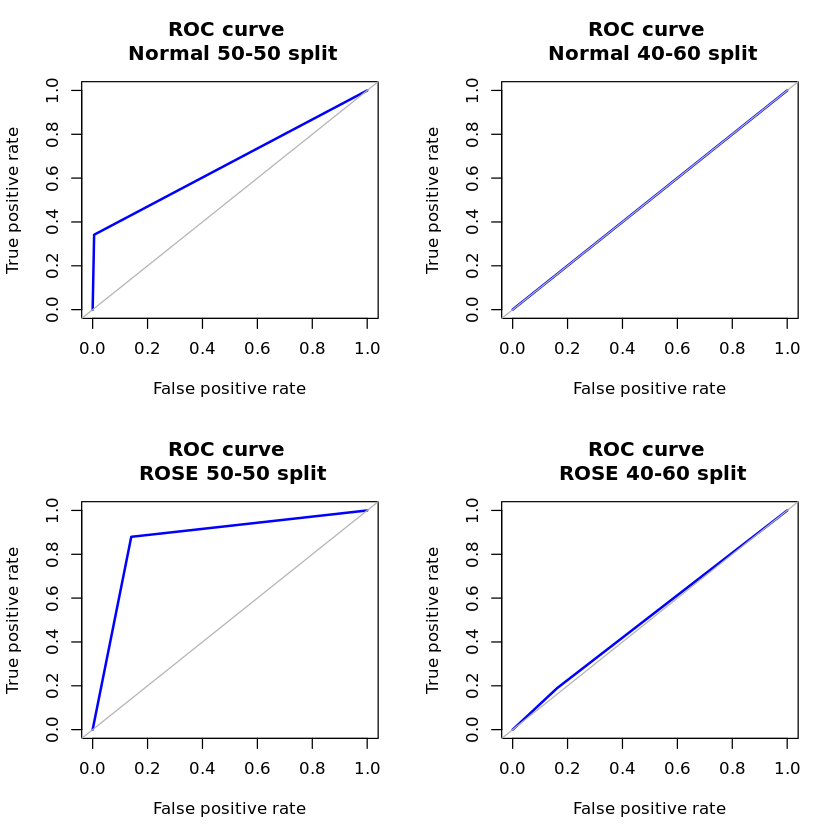

In [20]:
# We do 50/50 split.
ind = 0.5*length(default)
train = train = Default[1:ind,]
test = Default[(ind+1):length(default),]
default_test = default[(ind+1):length(default)]

# We do 40/60 split.
ind2 = 0.4*length(default)
train2 = train = Default[1:ind2,]
test2 = Default[(ind2+1):length(default),]
default_test2 = default[(ind2+1):length(default)]

# Train logistic classifier on normal training and test split.
glm.normal = glm(default~.,data=train,family=binomial)
glm.normal.probs = predict(glm.normal,test,type='response')
glm.normal.pred= rep('No',5000)
glm.normal.pred[glm.normal.probs>.5] = 'Yes'
table(glm.normal.pred,truth = default_test)


#Rose method
data.rose = ROSE(default~.,data=train,seed=1)$data
glm.rose = glm(default~.,data=data.rose,family=binomial)
glm.rose.probs = predict(glm.rose,test,type='response')
#glm.rose.transformed = sqrt(glm.rose.probs)
glm.rose.pred= rep('No',5000)
glm.rose.transformed.pred = rep('No',5000)
glm.rose.pred[glm.rose.probs>.5] = 'Yes'
#glm.rose.transformed.pred[glm.rose.transformed >.5] = 'Yes'
table(prediction= glm.rose.pred,truth =test$default)
#table(prediction = glm.rose.transformed.pred,actual=test$default)

#Rose method
data.rose2 = ROSE(default~.,data=train2,seed=1)$data
glm.rose2 = glm(default~.,data=data.rose2,family=binomial)
glm.rose2.probs = predict(glm.rose2,test,type='response')
#glm.rose2.transformed = sqrt(glm.rose2.probs)
glm.rose2.pred= rep('No',6000)
#glm.rose2.transformed.pred = rep('No',6000)
glm.rose2.pred[glm.rose2.probs>.5] = 'Yes'
#glm.rose2.transformed.pred[glm.rose2.transformed >.5] = 'Yes'
table(prediction= glm.rose2.pred,truth=default_test2)
#table(prediction = glm.rose2.transformed.pred,actual=default_test2)



# Train logistic classifier on normal training and test split.
glm.normal1 = glm(default~.,data=train2,family=binomial)
glm.normal1.probs = predict(glm.normal1,test,type='response')
glm.normal1.pred= rep('No',6000)
glm.normal1.pred[glm.normal1.probs>.5] = 'Yes'
table(glm.normal1.pred,truth=default_test2)

par(mfrow=c(2,2))
roc.curve(default_test,glm.normal.pred,  main="ROC curve \n Normal 50-50 split", col ='blue')
roc.curve(default_test2,glm.normal1.pred,  main="ROC curve \n Normal 40-60 split", col ='blue')
roc.curve(test$default,glm.rose.pred, main = 'ROC curve \n ROSE 50-50 split', col='blue')
roc.curve(default_test2,glm.rose2.pred, main = 'ROC curve \n ROSE 40-60 split', col='blue')

We notice that classification outcomes depend on the training and test set sizes. 

## Will I default? Test the normal logstic regression classifier on one instance

Suppose I'm not a student whose balance is 1,000 and income 35,000. I want to know if I am a defaulter or not. 

In [36]:
mydata = c('No','No',5000,5000)
mydata = as.data.frame(t(mydata))
colnames(mydata) = c('default','student','balance','income')
mydata$default = as.factor(mydata$default)
mydata$student = as.factor(mydata$student)
mydata$balance = as.numeric(mydata$balance)
mydata$income = as.numeric(mydata$income)
glm.normal.probs = predict(glm.normal,mydata,type='response')
new_probs = (glm.normal.probs)^(1/10)
#print(glm.normal.probs)^(1/10)
#print(new_probs)
#glm.rose2.transformed = sqrt(glm.rose2.probs)
pred = ifelse(new_probs>.3,"Yes","No")
print(pred)
print(paste('Will Li default? The classifier says:',pred))

    1 
"Yes" 
[1] "Will Li default? The classifier says: Yes"


# Conclusion

We have shown how dataset with imblanced labels will yield a poor classifier. By creating a balanced dataset using various sampling methods, we created classifiers that outperform one that was built on an imbalanced training set. Furthermore, in all cases where a balanced training set was used to build a classifier, fewer misclassifications on true defaulters were made compared to a naive model training on an imbalanced label data. 

Nevertheless, we also notice several issues that need to be addressed:
1. The size of the training and test data split yield different performance results. How should we split the data to get a better model performance?

2. Different threshold values used to determine defaulters vs non defaulters result in different confusion matrices. What is the optimal threshold value that yield fewer misclassifations?

3. Since the data is not a time series, we can create a training set based on random sampling as opposed to having the first 5,000 observations as the training set. In that case, what are the performances of our classifiers above?

4. We only fit our classifier using logistic regression. How are the logstic regression classifiers compared to other classification alghorithms? 


